In [272]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import Binarizer, KBinsDiscretizerKernelCenterer
from tqdm import tqdm_notebook
import catboost
from catboost import CatBoostRegressor, Pool, cv
from sklearn.metrics import accuracy_score

from catboost import cv

%matplotlib inline

In [261]:
train = pd.read_csv('../infopulsehackathon/train.csv', index_col='Id')
test = pd.read_csv('../infopulsehackathon/test.csv', index_col='Id')

In [262]:
y = train['Energy_consumption']
train.drop(columns=['Energy_consumption'], inplace=True)

In [263]:
df = pd.concat((train, test))

In [264]:
one_val = ['feature_226', 'feature_231']

In [707]:
num_feature = ['feature_267', 'feature_280', 'feature_281'] # need Scatter

In [265]:
# first_iter = ['feature_174', 'feature_243', 'feature_241', 'feature_240', 'feature_239', 'feature_237', 'feature_236', 'feature_233', 'feature_228', 'feature_57', 'feature_58', 'feature_245', 'feature_192', 'feature_124', 'feature_69', 'feature_120', 'feature_119', 'feature_216', 'feature_84', 'feature_90', 'feature_214', 'feature_213', 'feature_212', 'feature_222', 'feature_247', 'feature_235', 'feature_258', 'feature_159', 'feature_13']

In [266]:
# next_iter = ['feature_79',
#  'feature_85',
#  'feature_238',
#  'feature_74',
#  'feature_73',
#  'feature_210',
#  'feature_211']

In [267]:
df = df.drop(columns=one_val)

In [268]:
num_unique = df.agg(lambda x: len(np.unique(x)))

In [269]:
num_unique.value_counts().sort_index().head()

2    41
3    53
4    25
5    32
6    24
dtype: int64

In [270]:
cat_features = df.dtypes[df.dtypes == object].index.to_list()

In [271]:
cat_features

['feature_3', 'feature_4', 'feature_257', 'feature_258']

In [402]:
counts, vals = np.histogram(y, 9)

In [403]:
counts, vals

(array([1392, 1524,  729,  264,   64,   14,    5,    2,    6]),
 array([   36.27280739,  1398.37358145,  2760.4743555 ,  4122.57512956,
         5484.67590361,  6846.77667767,  8208.87745172,  9570.97822578,
        10933.07899983, 12295.17977389]))

In [404]:
y.min(), y.max()

(36.27280738970797, 12295.179773890264)

In [405]:
bins = []
for val in y:
    for inx, (val1, val2) in enumerate(zip(vals[:-1],vals[1:])):
        if val1<=val<=val2:
            bins.append(inx)

In [406]:
counts

array([1392, 1524,  729,  264,   64,   14,    5,    2,    6])

In [407]:
pd.Series(bins).value_counts()

1    1524
0    1392
2     729
3     264
4      64
5      14
8       6
6       5
7       2
dtype: int64

In [791]:
X_train, X_test, y_train, y_test = train_test_split(df[:len(y)], y, test_size=0.2, random_state=42)
train_pool = Pool(X_train, np.log(y_train), cat_features=cat_features)
test_pool = Pool(X_test, np.log(y_test), cat_features=cat_features)

In [794]:
X_train, X_test, y_train, y_test = train_test_split(df[:len(y)], y, test_size=0.2, random_state=42)
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [523]:
# train_pool = Pool(df[:len(y)], np.log(y+1), cat_features=cat_features)
# test_pool = Pool(df[len(y):], cat_features=cat_features)

In [524]:
# {'depth': 5, 'l2_leaf_reg': 1, 'learning_rate': 0.03} 575399.6381688283
# {'depth': 4, 'l2_leaf_reg': 1, 'learning_rate': 0.04} 589254.6306590807 loss: 805.3548328	best: 805.3548328 (6)
# {'depth': 4,
#  'l2_leaf_reg': 1,
#  'subsample': 0.7,
#  'learning_rate': 0.05,
#  'bootstrap_type': 'Bernoulli'} 574844.1419784756

In [531]:
model = CatBoostRegressor(iterations=1000, random_seed=42, eval_metric='RMSE', od_type='Iter',od_wait=100)

In [532]:
grid = {
    'depth': [3, 4, 5],
    'l2_leaf_reg': [1],
    'subsample': [0.7, 0.8, 0.9],
    'learning_rate': [0.05, 0.3],
    'bootstrap_type': ['Bernoulli']
}
# grid = {}

In [533]:
grid = {'depth': [4],
 'l2_leaf_reg': [1],
 'subsample': [0.7],
 'learning_rate': [0.05],
 'bootstrap_type': ['Bernoulli']}

In [534]:
grid_search_results = model.grid_search(grid, train_pool, cv=5, shuffle=True, verbose=3, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.3923920	best: 0.3923920 (0)	total: 6s	remaining: 0us
Estimating final quality...


In [535]:
grid_search_results['params']

{'depth': 4,
 'l2_leaf_reg': 1,
 'subsample': 0.7,
 'learning_rate': 0.05,
 'bootstrap_type': 'Bernoulli'}

In [536]:
mean_squared_error(y_test, np.exp(model.predict(test_pool)))

582922.4300235076

In [436]:
mean_squared_error(y_test, np.exp(model.predict(test_pool)))

625722.9190311785

In [355]:
mean_squared_error(y_test, model.predict(test_pool))

640408.8001100143

In [245]:
mean_squared_error(y_test, model.predict(test_pool))

580373.1277458454

In [700]:
feature_importances = pd.Series(dict(zip(X_train.columns, model.feature_importances_))).sort_values()

In [701]:
selected_features = feature_importances[feature_importances == 0].index.to_list()

In [223]:
selected_features

['feature_79',
 'feature_85',
 'feature_238',
 'feature_74',
 'feature_73',
 'feature_210',
 'feature_211']

In [184]:
print(selected_features)

['feature_174', 'feature_243', 'feature_241', 'feature_240', 'feature_239', 'feature_237', 'feature_236', 'feature_233', 'feature_228', 'feature_57', 'feature_58', 'feature_245', 'feature_192', 'feature_124', 'feature_69', 'feature_120', 'feature_119', 'feature_216', 'feature_84', 'feature_90', 'feature_214', 'feature_213', 'feature_212', 'feature_222', 'feature_247', 'feature_235', 'feature_258', 'feature_159', 'feature_13']


In [126]:
mean_squared_error(y_test, model.predict(test_pool))

597437.6652017508

In [77]:
mean_squared_error(y_test, model.predict(test_pool))

574844.1419784756

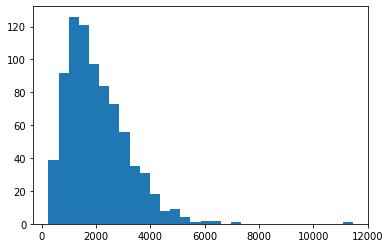

In [511]:
plt.hist(np.exp(model.predict(test_pool))-1, bins=30);

In [512]:
plt.hist(y, bins=30);

In [470]:
subm = pd.read_csv('../infopulsehackathon/sample_submission.csv')

In [471]:
subm['Energy_consumption'] = np.exp(model.predict(test_pool)) - 1

In [472]:
# subm.to_csv('predict_4_cat_and_log.csv', index=False)

In [661]:
zeros = df[(df.dtypes[df.dtypes!=object]).index].agg(lambda x: sum(x<0))
minus_two = df[(df.dtypes[df.dtypes!=object]).index].agg(lambda x: sum(x==-2))
minus_289 = df[(df.dtypes[df.dtypes!=object]).index].agg(lambda x: sum(x==-2)+sum(x==-8)+sum(x==-9))

In [720]:
with_none = minus_289[minus_289!=0].index

In [730]:
select = df[with_none]

In [734]:
select[select< 0] =None

/Users/adamobskiy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [740]:
df_with_none = pd.concat((select, df.drop(columns=with_none)), axis=1)

In [742]:
X_train, X_test, y_train, y_test = train_test_split(df_with_none[:len(y)], y, test_size=0.2, random_state=42)
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [750]:
model = CatBoostRegressor(iterations=1000, random_seed=42, eval_metric='RMSE', od_type='Iter',od_wait=100)

In [751]:
grid = {
    'depth': [3, 4, 5],
    'l2_leaf_reg': [1],
    'subsample': [0.7, 0.8, 0.9],
    'learning_rate': [0.05, 0.3],
    'bootstrap_type': ['Bernoulli']
}
# grid = {}

In [752]:
grid = {'depth': [4],
 'l2_leaf_reg': [1],
 'subsample': [0.7],
 'learning_rate': [0.05],
 'bootstrap_type': ['Bernoulli']}
grid = {}

In [753]:
grid_search_results = model.grid_search(grid, train_pool, cv=5, shuffle=True, verbose=3, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 817.4832518	best: 817.4832518 (0)	total: 11.5s	remaining: 0us
Estimating final quality...


In [754]:
grid_search_results['params']

{}

In [755]:
mean_squared_error(y_test, model.predict(test_pool))

583293.2601761053

In [756]:
from catboost import cv

In [ ]:
CatBoostRegressor()

In [795]:
def print_cv_summary(cv_data):
    cv_data.head(10)

    best_value = cv_data['test-RMSE-mean'].min()
    best_iter = cv_data['test-RMSE-mean'].values.argmin()

    print('Best validation Logloss score : {:.4f}±{:.4f} on step {}'.format(
        best_value,
        cv_data['test-RMSE-std'][best_iter],
        best_iter)
    )

In [796]:
# parameters for training inside cv:
params = {
    'depth': 5,
    'iterations': 1000,
    'learning_rate': 0.05
}

In [797]:
params = {}
params['loss_function'] = 'RMSE'
params['eval_metric'] = 'RMSE'
params['iterations'] = 1000
params['depth'] = 4
params['learning_rate'] = 0.05
params['subsample'] = 0.7
params['od_type'] = 'Iter'
params['od_wait'] = 100
params['bootstrap_type'] = 'Bernoulli'

In [798]:
cv_data = cv(
    params = params,
    pool = train_pool,
    fold_count=10,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [800]:
print_cv_summary(cv_data)

Best validation Logloss score : 810.2448±71.3746 on step 993


In [786]:
print_cv_summary(cv_data)

Best validation Logloss score : 827.6855±58.0802 on step 215


In [778]:
mean_squared_error(y_test, model.predict(test_pool))

583293.2601761053

In [749]:
mean_squared_error(y_test, model.predict(test_pool))

594343.1719061829

In [536]:
mean_squared_error(y_test, np.exp(model.predict(test_pool)))

582922.4300235076

In [662]:
(zeros != minus_two).sum()

23

In [666]:
(zeros != minus_289).sum()

3

In [703]:
zeros[zeros != minus_289].index

Index(['feature_267', 'feature_280', 'feature_281'], dtype='object')

In [693]:
df['feature_267'].hist(bins=30);

In [705]:
feature_importances

feature_285    0.000000
feature_236    0.000000
feature_235    0.000000
feature_232    0.000000
feature_35     0.000000
feature_214    0.000000
feature_213    0.000000
feature_210    0.000000
feature_57     0.000000
feature_58     0.000000
feature_159    0.000000
feature_61     0.000000
feature_133    0.000000
feature_79     0.000000
feature_119    0.000000
feature_110    0.000000
feature_237    0.000000
feature_238    0.000000
feature_90     0.000000
feature_240    0.000000
feature_241    0.000000
feature_247    0.000000
feature_7      0.000000
feature_239    0.000000
feature_245    0.000000
feature_281    0.001063
feature_62     0.001857
feature_180    0.002324
feature_134    0.003666
feature_69     0.003784
                 ...   
feature_98     0.829765
feature_267    0.833215
feature_81     0.849960
feature_141    0.858046
feature_256    0.929648
feature_86     0.936467
feature_91     0.951760
feature_253    0.981792
feature_93     1.042898
feature_173    1.067363
feature_52     1

In [664]:
df['feature_197'].value_counts()

-2    2806
-9    1972
 1     483
 0     424
-8       1
Name: feature_197, dtype: int64

In [622]:
df[num_unique[num_unique>100].index.to_list()].agg(lambda x: (x==0).sum())

feature_248     737
feature_249     257
feature_250       0
feature_251    1505
feature_252    2502
feature_253       0
feature_254      10
feature_255       4
feature_256    1090
feature_259      11
feature_260      13
feature_261     219
feature_262     229
feature_264     758
feature_265       0
feature_266       0
feature_267      12
feature_268    2384
feature_269    2801
feature_270    2952
feature_271    3855
feature_272    4813
feature_273    5302
feature_274    5113
feature_275    5312
feature_276    5473
feature_277    5384
feature_278    5392
feature_279    5402
dtype: int64

In [541]:
import seaborn as sns
from scipy.stats import norm
from scipy import stats

In [582]:
# df.dtypes[df.dtypes == float]
print(num_unique[num_unique>500].index.to_list())

['feature_248', 'feature_249', 'feature_250', 'feature_251', 'feature_252', 'feature_253', 'feature_254', 'feature_255', 'feature_256', 'feature_259', 'feature_260', 'feature_261', 'feature_262', 'feature_264', 'feature_265', 'feature_268', 'feature_269', 'feature_270', 'feature_271', 'feature_272', 'feature_274']


In [694]:
feature_name = 'feature_267'

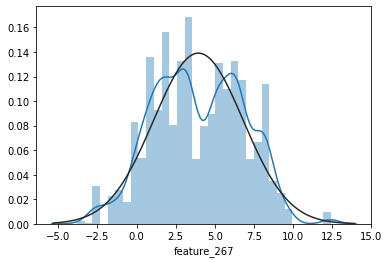

In [695]:
sns.distplot(df[feature_name], fit=norm);
fig = plt.figure()
res = stats.probplot(df[feature_name], plot=plt)

/Users/adamobskiy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


ValueError: cannot convert float NaN to integer

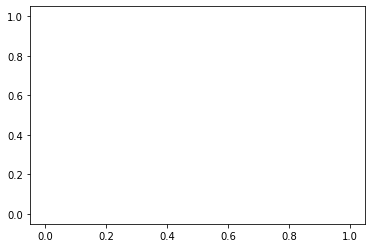

In [699]:
data_log = np.log(df[feature_name]+1)
sns.distplot(data_log, fit=norm);
fig = plt.figure()
res = stats.probplot(data_log, plot=plt)